# Đồ án cuối kỳ
# Môn: Xử lý dữ liệu lớn
# Học kỳ 1 - Năm học 2022-2023
# Giảng viên: Th.S. Nguyễn Thành An

# Cài đặt PySpark

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp drive/MyDrive/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

# Yêu cầu

In [4]:
myRootPath = 'drive/MyDrive/datasets'
reducedPath = 'drive/MyDrive/final_reduced_df'

## Spark Context

In [5]:
from pyspark import SparkContext
from pyspark.sql import SQLContext,SparkSession

#sc = SparkContext("local", 'CK')
#sqlc = SQLContext(sc)

sqlc = SparkSession.builder \
    .master('local[4]') \
    .config("spark.executor.memory", "50g")\
    .config("spark.driver.memory", "30g")\
    .config("spark.worker.memory", "22g")\
    .config("spark.memory.offHeap.enabled",'true')\
    .config("spark.memory.offHeap.size","12g")\
    .appName('CK') \
    .getOrCreate()


In [ ]:
!pip install python-resize-image

In [25]:
from pyspark.sql.functions import udf, col, monotonically_increasing_id
from matplotlib import pyplot as plt
from pyspark.mllib.linalg import DenseMatrix
from pyspark.mllib.linalg.distributed import RowMatrix
import random
import numpy as np
import math

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors

from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.stat import Correlation

from PIL import Image
from resizeimage import resizeimage
import cv2

## Câu 1: Giảm số chiều với SVD

#### Read df

In [ ]:
def txtToTuple(line):
  values = line[0].split(',')
  return (int(values[0]), int(values[1]), [int(val) for val in values[2:]])

In [ ]:
train_df = sqlc.read\
  .options()\
  .text(myRootPath + '/oxford_pet3_train.csv')
  
train_df = train_df.rdd\
  .map(lambda line: txtToTuple(line))\
  .toDF(['index','label','features'])

#### i. Hiển thị

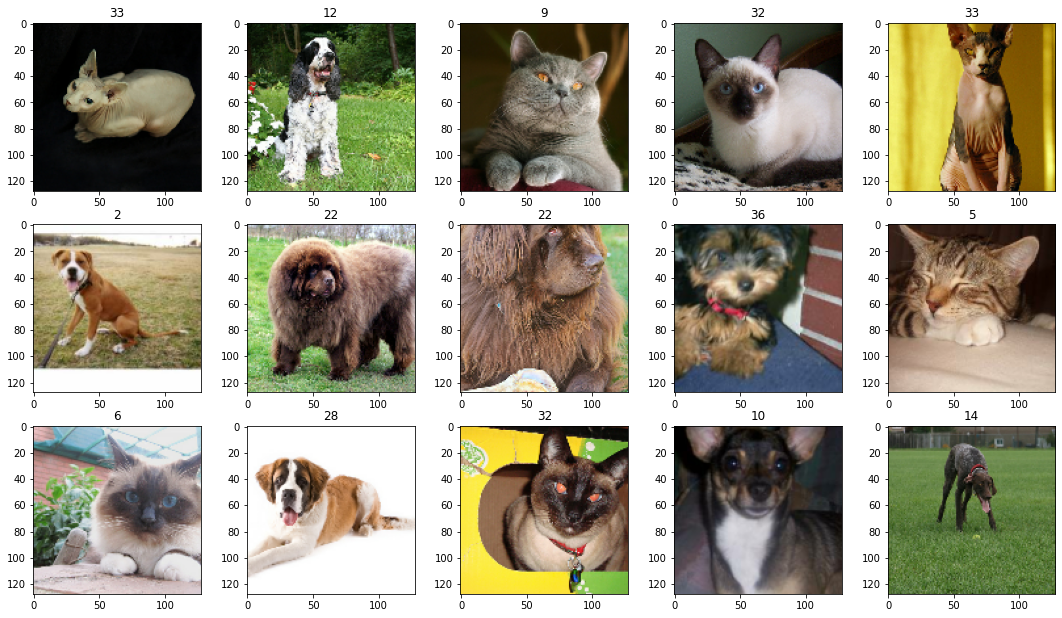

In [ ]:
fig, axs = plt.subplots(3,5)
fig.set_size_inches(18.5, 10.5)

count = 0
for row in train_df.head(15):
  img_mat = np.array(row[2]).reshape(128,128,3)

  if(count < 5):
    axs[0,count].imshow(img_mat)
    axs[0,count].set_title(row[1])
  elif(count < 10):
    axs[1,count-5].imshow(img_mat)
    axs[1,count-5].set_title(row[1])
  else:
    axs[2,count-10].imshow(img_mat)
    axs[2,count-10].set_title(row[1])

  count += 1

plt.show()

#### ii. Giảm số chiều SVD

##### Test reduction algo

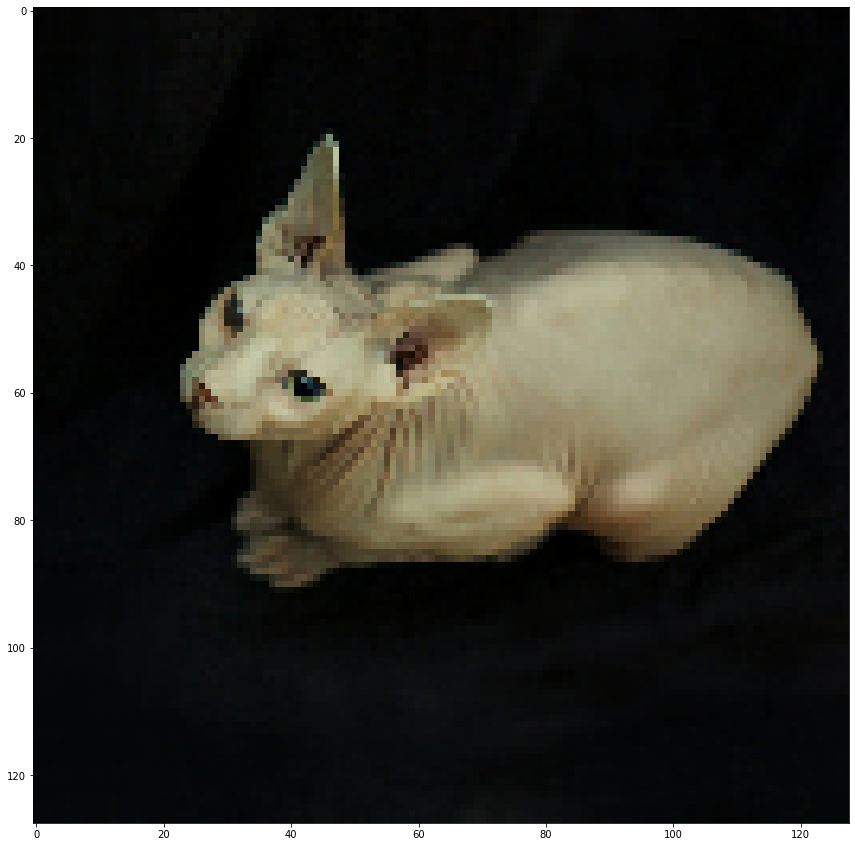

In [ ]:
#1 line ex
with open(myRootPath + '/oxford_pet3_train.csv', 'r') as f:
  line = f.readline().split(',')
  tmp = (int(line[0]), int(line[1]), [int(val) for val in line[2:]])
  features = np.array(tmp[2]).reshape(128,128,3)
  
  r = features[:,:,0]
  g = features[:,:,1]
  b = features[:,:,2]

  f = np.zeros((128, 128, 3))
  f[:, :, 0] = r
  f[:, :, 1] = g
  f[:, :, 2] = b
  f = np.around(f).astype(int)

  i = 64

  U_r, S_r, V_r = np.linalg.svd(r, full_matrices=False)
  U_g, S_g, V_g = np.linalg.svd(g, full_matrices=False)
  U_b, S_b, V_b = np.linalg.svd(b, full_matrices=False)

  r_c = np.matrix(U_r[:, :i]) * np.diag(S_r[:i]) * np.matrix(V_r[:i, :])
  g_c = np.matrix(U_g[:, :i]) * np.diag(S_g[:i]) * np.matrix(V_g[:i, :])
  b_c = np.matrix(U_b[:, :i]) * np.diag(S_b[:i]) * np.matrix(V_b[:i, :])

  f_c = np.zeros((128, 128, 3))
  f_c[:, :, 0] = r_c
  f_c[:, :, 1] = g_c
  f_c[:, :, 2] = b_c
  f_c = np.around(f_c).astype(int)

  plt.figure(figsize=(15, 10))
  plt.imshow(f_c)
  plt.show()

In [ ]:
f_c.reshape(1,49152)[0].tolist()

array([5, 3, 3, ..., 3, 6, 7])

##### Main reduce logic:

In [ ]:
def svdOnEachLine(line, r=64):
  features = np.array(line[2]).reshape(128,128,3)
  
  rd = features[:,:,0]
  g = features[:,:,1]
  b = features[:,:,2]

  f = np.zeros((128, 128, 3))
  f[:, :, 0] = rd
  f[:, :, 1] = g
  f[:, :, 2] = b
  f = np.around(f).astype(int)

  U_r, S_r, V_r = np.linalg.svd(rd, full_matrices=False)
  U_g, S_g, V_g = np.linalg.svd(g, full_matrices=False)
  U_b, S_b, V_b = np.linalg.svd(b, full_matrices=False)

  r_c = np.matrix(U_r[:, :r]) * np.diag(S_r[:r]) * np.matrix(V_r[:r, :])
  g_c = np.matrix(U_g[:, :r]) * np.diag(S_g[:r]) * np.matrix(V_g[:r, :])
  b_c = np.matrix(U_b[:, :r]) * np.diag(S_b[:r]) * np.matrix(V_b[:r, :])

  f_c = np.zeros((128, 128, 3))
  f_c[:, :, 0] = r_c
  f_c[:, :, 1] = g_c
  f_c[:, :, 2] = b_c
  f_c = np.around(f_c).astype(int)

  arr_1d = f_c.reshape(1,49152)[0].tolist()
  return (line[0], line[1], arr_1d)

In [ ]:
def toCSVLine(tup):
  line = str(tup[0]) + ',' + str(tup[1]) + ','
  line = line + ','.join(str(val) for val in tup[2])

  return line

In [ ]:
reduced_rdd = train_df.rdd\
  .map(lambda line: svdOnEachLine(line))\
  .map(lambda line: toCSVLine(line))

In [ ]:
reduced_rdd.saveAsTextFile(reducedPath+ '/r_train_64.csv')

In [ ]:
r_train_df = sqlc.read\
  .options()\
  .text(reducedPath + '/r_train_64.csv')
  
r_train_df = r_train_df.rdd\
  .map(lambda line: txtToTuple(line))\
  .toDF(['index','label','features'])

r_train_df.show(5)

+-----+-----+--------------------+
|index|label|            features|
+-----+-----+--------------------+
|    0|   33|[5, 3, 3, 5, 4, 3...|
|    1|   12|[6, 13, 2, 19, 30...|
|    2|    9|[34, 25, 2, 34, 2...|
|    3|   32|[92, 113, 103, 10...|
|    4|   33|[232, 226, 93, 23...|
+-----+-----+--------------------+
only showing top 5 rows



##### Do the same for test

In [ ]:
test_df = sqlc.read\
  .options()\
  .text(myRootPath + '/oxford_pet3_test.csv')
  
test_df = test_df.rdd\
  .map(lambda line: txtToTuple(line))\
  .toDF(['index','label','features'])

In [ ]:
reduced_test_rdd = test_df.rdd\
  .map(lambda line: svdOnEachLine(line))\
  .map(lambda line: toCSVLine(line))

In [ ]:
reduced_test_rdd.saveAsTextFile(reducedPath+ '/r_test_64.csv')

In [ ]:
r_test_df = sqlc.read\
  .options()\
  .text(reducedPath + '/r_test_64.csv')
  
r_test_df = r_test_df.rdd\
  .map(lambda line: txtToTuple(line))\
  .toDF(['index','label','features'])

r_test_df.show(5)

+-----+-----+--------------------+
|index|label|            features|
+-----+-----+--------------------+
|    0|   19|[251, 245, 233, 2...|
|    1|   20|[3, 4, 1, 2, 2, 0...|
|    2|   28|[119, 130, 35, 91...|
|    3|   28|[180, 155, 113, 1...|
|    4|    4|[188, 187, 200, 1...|
+-----+-----+--------------------+
only showing top 5 rows



## Câu 2: Khuyến nghị sản phẩm với Collaborative Filtering

In [ ]:
plt.style.use('bmh')

In [ ]:
# Doc du lieu
rating = sqlc.read.csv(myRootPath + '/ratings2k.csv', header=True)
rating.show(10)

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    2|  72|  26|   1.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
|    5|  36| 277|   3.0|
|    6|  72| 426|   4.0|
|    7|  18| 163|   3.0|
|    8|  67|  93|   4.0|
|    9|  59|  22|   3.5|
+-----+----+----+------+
only showing top 10 rows



In [ ]:
# Chuan hoa
rating = rating\
  .withColumn('user', col('user')\
  .cast(IntegerType()))
rating = rating\
  .withColumn('item', col('item')\
  .cast(IntegerType()))
rating = rating\
  .withColumn('rating', col('rating')\
  .cast(FloatType()))
rating.show(10)

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    2|  72|  26|   1.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
|    5|  36| 277|   3.0|
|    6|  72| 426|   4.0|
|    7|  18| 163|   3.0|
|    8|  67|  93|   4.0|
|    9|  59|  22|   3.5|
+-----+----+----+------+
only showing top 10 rows



In [ ]:
# Tach du lieu
rating_train = rating.where(col('user') <= 70)
rating_train.show(10)

rating_test = rating.where((col('user') > 70) & (col('user') < 75))
rating_test.show(10)

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    1|  36| 239|   3.0|
|    3|  59| 430|   2.5|
|    5|  36| 277|   3.0|
|    7|  18| 163|   3.0|
|    8|  67|  93|   4.0|
|    9|  59|  22|   3.5|
|   10|   8| 174|   2.0|
|   11|   5| 149|   2.0|
|   12|  26| 322|   3.5|
|   13|   8| 416|   4.0|
+-----+----+----+------+
only showing top 10 rows

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    2|  72|  26|   1.0|
|    4|  72| 284|   3.0|
|    6|  72| 426|   4.0|
|   25|  72|  49|   3.0|
|   30|  72| 184|   4.0|
|   37|  73|  18|   4.0|
|   41|  72| 435|   4.0|
|   43|  72| 238|   2.0|
|   52|  72| 186|   3.0|
+-----+----+----+------+
only showing top 10 rows



In [ ]:
# Huan luyen
als = ALS(coldStartStrategy="drop", nonnegative=True, implicitPrefs=True, userCol="user", itemCol="item", ratingCol="rating")
rating_model = als.fit(rating)

In [ ]:
# Du doan
rating_pred = rating_model.transform(rating_test)
rating_pred.show(10)

+-----+----+----+------+----------+
|index|user|item|rating|prediction|
+-----+----+----+------+----------+
|  868|  72|  85|   3.0|0.89552927|
|  140|  72| 251|   5.0|0.96495485|
|  463|  71| 251|   5.0|0.52413684|
| 1931|  74| 251|   4.0| 0.7761289|
| 2208|  72| 451|   4.0| 0.9136245|
| 2075|  72| 255|   3.0|0.86238134|
|  565|  72| 322|   4.0| 0.8709408|
| 2202|  71| 322|   5.0| 0.5031602|
| 1617|  74| 322|   3.0|  0.771327|
| 1505|  72| 321|   2.0| 0.7695774|
+-----+----+----+------+----------+
only showing top 10 rows



In [ ]:
# So sanh tuong dong
rating_pred.corr('rating', 'prediction')

0.14332703165450597

In [ ]:
# Sai so
rating_eval = RegressionEvaluator(metricName="mse", 
                                  labelCol="rating", 
                                  predictionCol="prediction")
rating_mse = rating_eval.evaluate(rating_pred)
rating_mse

8.050668345144764

## Câu 3: Dự đoán giá chứng khoán

In [ ]:
# Doc du lieu
stock = sqlc.read.csv(myRootPath + '/stockHVN2022.csv', header=True)
stock.show(10)

+----------+-----+
|      Ngay|  HVN|
+----------+-----+
|18/11/2022| 9.30|
|17/11/2022| 9.42|
|16/11/2022| 9.21|
|15/11/2022| 8.61|
|14/11/2022| 9.25|
|11/11/2022| 9.90|
|10/11/2022| 9.76|
|09/11/2022|10.40|
|08/11/2022|10.25|
|07/11/2022|10.10|
+----------+-----+
only showing top 10 rows



In [ ]:
# Chuan hoa
def convertDate(date):
  tmp = date.split('/')

  return '/'.join([tmp[2], tmp[1], tmp[0]])

stock_stand = stock\
  .withColumn('ID', monotonically_increasing_id())\
  .withColumn('Date', udf(convertDate)(col('Ngay')))\
  .select(['ID', 'Date', 'HVN'])

stock_stand.show(10)

stock_stand.registerTempTable('Stock')

stock_stand = sqlc.sql(''' \
  SELECT CAST(P5.HVN AS DOUBLE) AS p5, 
    CAST(P4.HVN AS DOUBLE) AS p4, 
    CAST(P3.HVN AS DOUBLE) AS p3, 
    CAST(P2.HVN AS DOUBLE) AS p2, 
    CAST(P1.HVN AS DOUBLE) AS p1, 
    CAST(T.HVN AS DOUBLE) AS next_day, 
    T.Date
  FROM Stock T
  JOIN Stock P1 ON P1.ID = T.ID - 1
  JOIN STOCK P2 ON P2.ID = T.ID - 2
  JOIN STOCK P3 ON P3.ID = T.ID - 3
  JOIN STOCK P4 ON P4.ID = T.ID - 4
  JOIN STOCK P5 ON P5.ID = T.ID - 5
''')

stock_stand.show(10, truncate=False)

va = VectorAssembler(inputCols=['p5', 'p4', 'p3', 'p2', 'p1'], 
                    outputCol='prev_days')
va_stock_stand = va.transform(stock_stand)
va_stock_stand.show(5)

+---+----------+-----+
| ID|      Date|  HVN|
+---+----------+-----+
|  0|2022/11/18| 9.30|
|  1|2022/11/17| 9.42|
|  2|2022/11/16| 9.21|
|  3|2022/11/15| 8.61|
|  4|2022/11/14| 9.25|
|  5|2022/11/11| 9.90|
|  6|2022/11/10| 9.76|
|  7|2022/11/09|10.40|
|  8|2022/11/08|10.25|
|  9|2022/11/07|10.10|
+---+----------+-----+
only showing top 10 rows

+-----+-----+-----+-----+-----+--------+----------+
|p5   |p4   |p3   |p2   |p1   |next_day|Date      |
+-----+-----+-----+-----+-----+--------+----------+
|9.3  |9.42 |9.21 |8.61 |9.25 |9.9     |2022/11/11|
|9.42 |9.21 |8.61 |9.25 |9.9  |9.76    |2022/11/10|
|9.21 |8.61 |9.25 |9.9  |9.76 |10.4    |2022/11/09|
|8.61 |9.25 |9.9  |9.76 |10.4 |10.25   |2022/11/08|
|9.25 |9.9  |9.76 |10.4 |10.25|10.1    |2022/11/07|
|9.9  |9.76 |10.4 |10.25|10.1 |10.7    |2022/11/04|
|9.76 |10.4 |10.25|10.1 |10.7 |10.85   |2022/11/03|
|10.4 |10.25|10.1 |10.7 |10.85|10.9    |2022/11/02|
|10.25|10.1 |10.7 |10.85|10.9 |10.9    |2022/11/01|
|10.1 |10.7 |10.85|10.9 |10.

In [ ]:
# Tach du lieu
stock_train = va_stock_stand.where(col('Date') < '2022/09/01').select(['prev_days', 'next_day'])
stock_train.show(10, truncate=False)

stock_test = va_stock_stand.where(col('Date') >= '2022/09/01').select(['prev_days', 'next_day'])
stock_test.show(10, truncate=False)

+------------------------------+--------+
|prev_days                     |next_day|
+------------------------------+--------+
|[14.85,15.15,16.25,16.85,17.0]|17.25   |
|[15.15,16.25,16.85,17.0,17.25]|17.1    |
|[16.25,16.85,17.0,17.25,17.1] |17.05   |
|[16.85,17.0,17.25,17.1,17.05] |17.65   |
|[17.0,17.25,17.1,17.05,17.65] |17.9    |
|[17.25,17.1,17.05,17.65,17.9] |17.9    |
|[17.1,17.05,17.65,17.9,17.9]  |17.45   |
|[17.05,17.65,17.9,17.9,17.45] |17.4    |
|[17.65,17.9,17.9,17.45,17.4]  |17.4    |
|[17.9,17.9,17.45,17.4,17.4]   |17.35   |
+------------------------------+--------+
only showing top 10 rows

+----------------------------+--------+
|prev_days                   |next_day|
+----------------------------+--------+
|[9.3,9.42,9.21,8.61,9.25]   |9.9     |
|[9.42,9.21,8.61,9.25,9.9]   |9.76    |
|[9.21,8.61,9.25,9.9,9.76]   |10.4    |
|[8.61,9.25,9.9,9.76,10.4]   |10.25   |
|[9.25,9.9,9.76,10.4,10.25]  |10.1    |
|[9.9,9.76,10.4,10.25,10.1]  |10.7    |
|[9.76,10.4,10.25,10.1,10.

In [ ]:
# Huan luyen
lr = LinearRegression(featuresCol='prev_days', labelCol='next_day', regParam=0.3, elasticNetParam=0.8)
stock_model = lr.fit(stock_train)

+--------------------+--------+------------------+
|           prev_days|next_day|        prediction|
+--------------------+--------+------------------+
|[9.3,9.42,9.21,8....|     9.9|10.074149573762746|
|[9.42,9.21,8.61,9...|    9.76|10.507840900023188|
|[9.21,8.61,9.25,9...|    10.4|10.585396237432327|
+--------------------+--------+------------------+
only showing top 3 rows



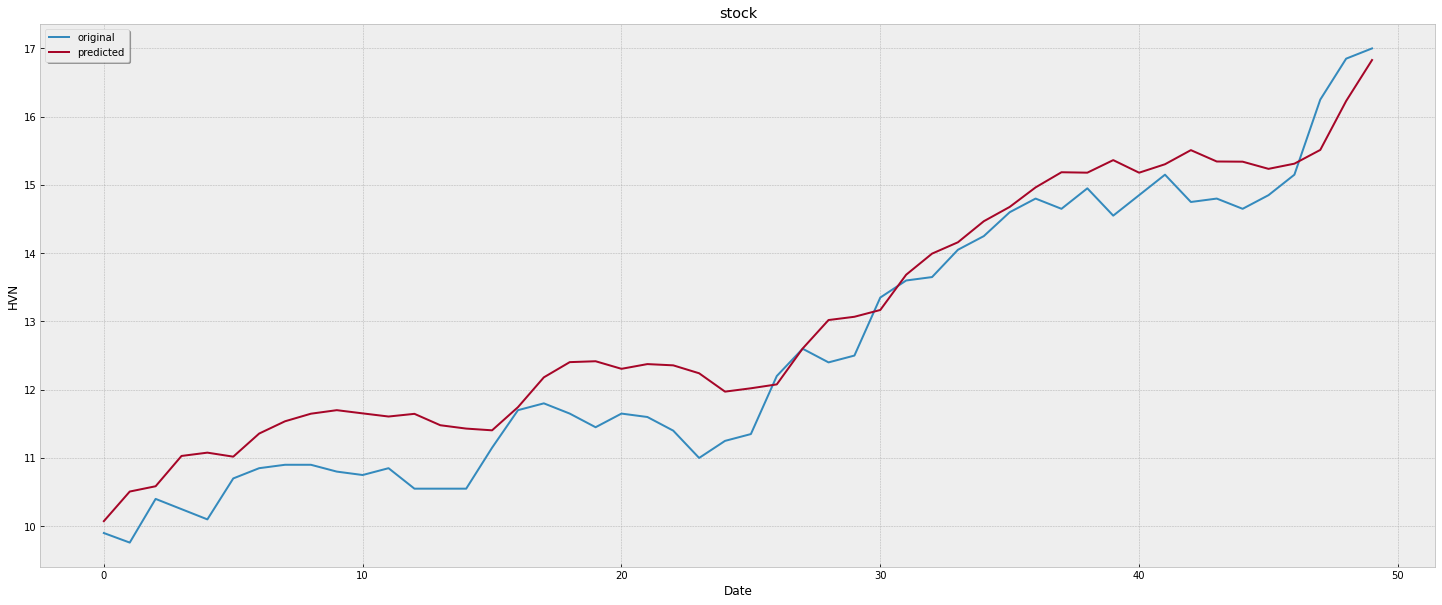

In [ ]:
# Du doan
stock_pred = stock_model.transform(stock_test)
stock_pred.show(3)

x_ax = range(0, stock_pred.count())
y_pred = stock_pred.select("prediction").collect()
y_orig = stock_pred.select("next_day").collect()  

plt.figure(figsize=(25,10))
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("stock")
plt.xlabel('Date')
plt.ylabel('HVN')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [ ]:
# Sai so
stock_result = stock_model.evaluate(stock_test)
stock_result.meanSquaredError

0.3861755470405241

## Câu 4: Phân loại đa lớp với pyspark

##### Image preproccessing

[4.0,4.0,7.0,4.0,4.0,7.0,5.0,6.0,6.0,7.0,10.0,10.0,12.0,13.0,13.0,12.0,12.0,11.0,6.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,7.0,6.0,6.0,3.0,3.0,7.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0,7.0,11.0,11.0,9.0,5.0,5.0,6.0,7.0,7.0,6.0,3.0,4.0,5.0,3.0,3.0,2.0,2.0,4.0,3.0,5.0,3.0,4.0,3.0,2.0,3.0,4.0,4.0,5.0,3.0,5.0,8.0,8.0,6.0,8.0,7.0,11.0,11.0,12.0,14.0,12.0,11.0,13.0,10.0,5.0,4.0,5.0,6.0,3.0,3.0,3.0,3.0,7.0,6.0,5.0,3.0,2.0,5.0,5.0,4.0,4.0,6.0,5.0,3.0,5.0,8.0,12.0,12.0,8.0,5.0,5.0,5.0,6.0,7.0,6.0,4.0,5.0,4.0,3.0,3.0,3.0,2.0,2.0,3.0,4.0,3.0,3.0,3.0,2.0,3.0,5.0,4.0,4.0,3.0,5.0,7.0,5.0,5.0,8.0,6.0,8.0,11.0,13.0,13.0,11.0,13.0,11.0,6.0,3.0,3.0,5.0,6.0,4.0,3.0,3.0,3.0,6.0,6.0,5.0,4.0,2.0,5.0,6.0,4.0,5.0,5.0,3.0,4.0,6.0,7.0,12.0,12.0,6.0,6.0,6.0,6.0,7.0,5.0,6.0,5.0,4.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,2.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,7.0,7.0,5.0,5.0,7.0,7.0,7.0,11.0,12.0,11.0,11.0,12.0,8.0,3.0,1.0,2.0,4.0,5.0,5.0,3.0,3.0,5.0,8.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,6.0,9.0,13.0,7.0,4.0,5.0,5.0,6.0,5.0,6.0,5.0,3

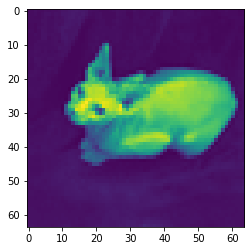

In [42]:
with open(myRootPath + '/oxford_pet3_train.csv', 'r') as f:
  line = f.readline().split(',')
  tmp = (int(line[0]), int(line[1]), [int(val) for val in line[2:]])
  input_img = np.array(tmp[2]).reshape(128,128,3)

  r, g, b = input_img[:,:,0], input_img[:,:,1], input_img[:, :, 2]
  gamma = 1.04

  r_const, g_const, b_const = 0.2126, 0.7152, 0.0722
  gray_img = r_const * r ** gamma + g_const * g ** gamma + b_const * b ** gamma

  size = 64
  img = Image.fromarray(gray_img)
  img.thumbnail((size,size))

  final_img = np.array(img)
  arr_1d = np.around(final_img).astype('int').reshape(1,size*size).tolist()[0]
  print(Vectors.dense(arr_1d))
  print(final_img.shape)
  plt.imshow(final_img)
  plt.show()

#### Default (train, test)

In [21]:
def grayScale(line):
  input_img = np.array(line[2]).reshape(128,128,3)
  r, g, b = input_img[:,:,0], input_img[:,:,1], input_img[:, :, 2]

  gamma = 1.04
  r_const, g_const, b_const = 0.2126, 0.7152, 0.0722
  
  gray_img = r_const * r ** gamma \
    + g_const * g ** gamma \
    + b_const * b ** gamma

  size = 64
  img = Image.fromarray(gray_img)
  img.thumbnail((size,size))

  final_img = np.array(img)
  arr_1d = np.around(final_img)\
    .astype('int')\
    .reshape(1,size*size)\
    .tolist()[0]

  return (line[1], Vectors.dense(arr_1d))

In [44]:
train_df_4 = train_df\
  .rdd\
  .map(lambda line: grayScale(line))\
  .toDF(['label', 'gray_img'])

In [45]:
layers = [4096, 128, 128, 37]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=123, featuresCol='gray_img', labelCol='label')

# train the model
# df must have 'features' column and its value must be pyspark.ml.Vectors Vectors.dense() type
model = trainer.fit(train_df_4)

In [46]:
test_df_4 = test_df\
  .rdd\
  .map(lambda line: grayScale(line))\
  .toDF(['label', 'gray_img'])

In [47]:
# compute accuracy on the test set
result = model.transform(test_df)
predictionAndLabels = result.select("prediction", "label")
predictionAndLabels.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|      21.0|   33|
|      21.0|   12|
|      21.0|    9|
|       7.0|   32|
|      21.0|   33|
+----------+-----+
only showing top 5 rows



In [52]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
eval_default = evaluator.evaluate(predictionAndLabels)
print("Test set accuracy = " + str(eval_default))

Test set accuracy = 0.04


#### Reduced (train,test)

In [8]:
r_train_df = sqlc.read\
  .options()\
  .text(reducedPath + '/r_train_64.csv')

r_train_df_4 = r_train_df.rdd\
  .map(lambda line: txtToTuple(line))\
  .map(lambda line: grayScale(line))\
  .toDF(['label', 'gray_img'])

In [27]:
r_test_df = sqlc.read\
  .options()\
  .text(reducedPath + '/r_test_64.csv')

r_test_df_4 = r_test_df.rdd\
  .map(lambda line: txtToTuple(line))\
  .map(lambda line: grayScale(line))\
  .toDF(['label', 'gray_img'])

In [28]:
layers = [4096, 128, 128, 37]

trainer = MultilayerPerceptronClassifier(maxIter=100, 
                                         layers=layers, 
                                         blockSize=128, 
                                         seed=123, 
                                         featuresCol='gray_img', 
                                         labelCol='label')

model = trainer.fit(r_train_df_4)

In [29]:
# compute accuracy on the test set
result = model.transform(r_test_df_4)
predictionAndLabels = result.select("prediction", "label")
predictionAndLabels.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|      12.0|   19|
|      21.0|   20|
|       7.0|   28|
|      32.0|   28|
|      27.0|    4|
+----------+-----+
only showing top 5 rows



In [30]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
eval_default = evaluator.evaluate(predictionAndLabels)
print("Test set accuracy = " + str(eval_default))

Test set accuracy = 0.03


#### Compare

In [31]:
titles= ['default', 'reduced']
accs  = [0.04, 0.03]

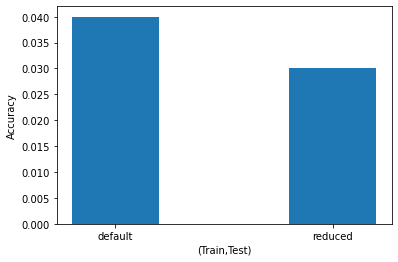

In [38]:
plt.bar(titles, accs, width = 0.4)
plt.ylabel("Accuracy")
plt.xlabel("(Train,Test)")

plt.show()